In [45]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import norm as gauss
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel
from skimage.transform import rescale

# Data augmentations

Now that we have field images, we can augment them to simulate different observing conditions.
Main augmentations are:

1. Convolve with a PSF to decrease seeing: `convolve_psf`
2. Rescale to a larger pixel scale: `change_pxscale`
3. Add noise to decrease detectable threshold: `add_noise`


**Important:** must apply noise **last**

In [164]:
path = "data/subhaloes"

RNG_LIMS = {
    "SB_MIN"      : 22,   # dimmest surface brightness. 23 is SDSS-like
    "SB_MAX"      : 27,   # below this, haloes will start having sharp edges
    "PSF_MAX"     : 10,   # maxmum psf (arcsec)
    "SCALE_FACTOR_MAX" : 3,  # allow changing pixel scale up to 1*SCALE_FACTOR_MAX or 1/SCALE_FACTOR_MAX
}

In [142]:
EXAMPLE = True

if EXAMPLE:
    test_id = "416531_1"
    file    = fits.open(f"{path}/{test_id}.fits")
    img     = np.array(file[0].data, dtype=np.float64)
    file.close()

## Individual augmentations

### Convolve with PSF

All images have a default pixel scale of 1". This is similar to SDSS.
We convolve with kernels of 1-5 px in size (1"-5")

* After convolving, add some noise to each pixel value to simulate read noise

In [143]:
def convolve_psf(image, fwhm):
    """Convolve with a Gaussian PSF with given full-width half-maximum
    INPUTS:
        image:  np.ndarray with the image
        fwhm:   FWHM of the PSF
    OUTPUTS:
        image_conv: convolved image
    """
    kernel     = Gaussian2DKernel(fwhm)
    image_conv = convolve(image, kernel)
#     sd         = sigma_clipped_stats(image_conv)
    return image_conv

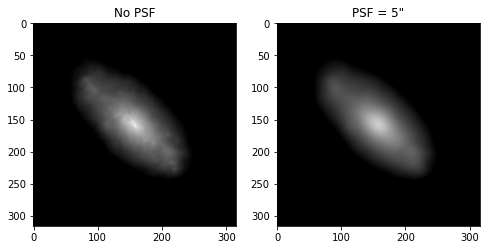

In [144]:
if EXAMPLE:
    
    img_conv = convolve_psf(img, 5)
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(-2.5*np.log10(np.abs(img)),      cmap="gray_r",  vmin=18, vmax=24); axs[0].set_title("No PSF")
    axs[1].imshow(-2.5*np.log10(np.abs(img_conv)), cmap="gray_r",  vmin=18, vmax=24); axs[1].set_title('PSF = 5"')

### Scale to a different pixel scale

Original pixel scale: 1 arcsec/px

* Flux units on all images are flux/arcsec$^2$ so we **do not** multiply flux when rescaling
* Technically noise level goes down this way


In [145]:
def change_pxscale(image, pxscale):
    """Rebin the image to a new pixel scale (resolution)
    INPUTS:
        image:   np.ndarray with the image
        pxscale: new pixel scale (arcsec)
    OUTPUTS:
        image_new: re-binned image
    """
    image_new = rescale(image, 1/pxscale)
#     image_new = image_new * (pxscale**2)
    return image_new

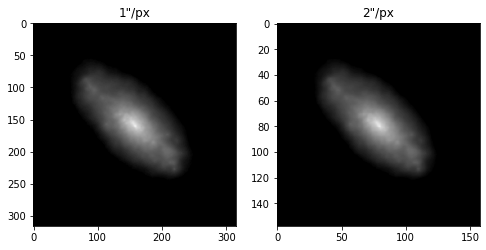

In [146]:
if EXAMPLE:
    img_rescaled = change_pxscale(img, 2)
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(-2.5*np.log10(np.abs(img)),          cmap="gray_r",  vmin=18, vmax=24); axs[0].set_title('1"/px')
    axs[1].imshow(-2.5*np.log10(np.abs(img_rescaled)), cmap="gray_r",  vmin=18, vmax=24); axs[1].set_title('2"/px')

### Add noise

All of the training images are created **with no background noise**. 
We can add extra noise:

\begin{equation}
    \sigma'^2 = 10^{-\frac{2M'}{2.5}}
\end{equation}

Range the noise levels from 23 to 27.

**Note:** SDSS noise level is about 21. But our galaxies are observed at a decently high redshift (0.116) and the actual resolution per kpc is much higher than it is for SDSS. The observations are more like HST for local objects. We could move the objects closer, but instead we train as is, because moving them closer increases image size significantly. The output should be useable with both HST-like data and SDSS-like data

In [154]:
def add_noise(image, sb):
    """Add noise to the image to match a given surface brightness (sky RMS in mags).
    INPUTS:
        image:       np.ndarray with the image
        sb:          desired surface brightess
    OUTPUTS:
        noisy_image
    """
    noise_add   = np.power(10, -sb/2.5)
    noise       = gauss.rvs(loc=0, scale=noise_add, size=image.shape)
    noisy_image = image + noise
    return noisy_image

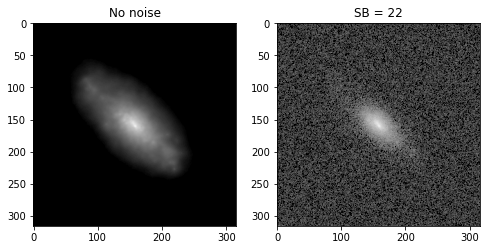

In [158]:
if EXAMPLE:
    
    img_noise = add_noise(img, 22)
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(-2.5*np.log10(np.abs(img)),       cmap="gray_r",  vmin=18, vmax=24); axs[0].set_title("No noise")
    axs[1].imshow(-2.5*np.log10(np.abs(img_noise)), cmap="gray_r",  vmin=18, vmax=24); axs[1].set_title("SB = 22")
 

## Combine transformations

1. Convolve with PSF: `convolve_psf`
2. Re-scale to a new pixelscale: `change_pxscale`
3. Add noise: `add_noise`

In [181]:
def transform_image(image, lims):
    
    req_limits = {"PSF_MAX", "SCALE_FACTOR_MAX", "SB_MIN", "SB_MAX"}
    assert req_limits.issubset(set(lims.keys())), "Make sure all RNG limits are in limits dict"
    
    # 1. Convolve with a PSF
    fwhm   = 1 + (lims["PSF_MAX"]-1)*np.random.random()
    image  = convolve_psf(image, fwhm)
    
    # 2. Change pixel scale; allow to decrease and increase the scale
    scale      = 1 + (lims["SCALE_FACTOR_MAX"]-1)*np.random.random()
    scale_down = True if np.random.random() < 0.5 else False
    pxscale    = scale if scale_down  else 1/scale
    image      = change_pxscale(image, pxscale)
    
    # 3. Add noise 
    sb         = lims["SB_MIN"] + (lims["SB_MAX"] - lims["SB_MIN"])*np.random.random()
    image      = add_noise(image, sb)
    
    return image

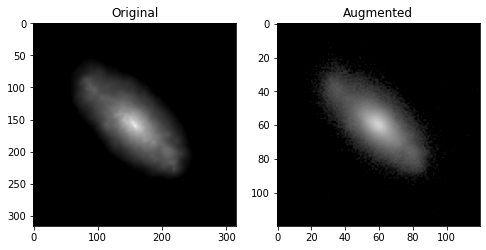

In [182]:
if EXAMPLE:   
    img_transformed = transform_image(img, RNG_LIMS)
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(-2.5*np.log10(np.abs(img)),             cmap="gray_r",  vmin=18, vmax=24); 
    axs[1].imshow(-2.5*np.log10(np.abs(img_transformed)), cmap="gray_r",  vmin=18, vmax=24); 
    axs[0].set_title("Original")
    axs[1].set_title("Augmented")
 